In [1]:
import detectron2
import torch
import copy
import pickle 
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper   # the default mapper
from detectron2.data import build_detection_train_loader
from detectron2.data import build_detection_test_loader
from detectron2.data import detection_utils as utils 
from detectron2.data.detection_utils import annotations_to_instances
from tqdm import tqdm 

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#for the mapepr
import copy
import logging
import numpy as np
from typing import List, Optional, Union
import torch

from detectron2.config import configurable

from detectron2.data import detection_utils as utils 
import detectron2.data.transforms as T

In [3]:
torch.__version__

'1.10.0'

In [4]:
!nvidia-smi

Sun Jan 22 18:46:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   40C    P0    64W / 300W |  26877MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   

# Register the dataset so that it can be used by dataloader

In [5]:
def get_detectron_train_data():
    data = [] #here is where we will collect the coco dicts
    root = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Detectron_Detection/Data/DetectronData/"
    xml_files = [
        "327_A1d_ASAP.xml", # data good
        "270_A1d_ASAP.xml", #looks good
        "131_B1e_ASAP_fixed.xml" #data good, 
        "41_A2c_ASAP_fixed.xml" #good, 
        "51_D1b_ASAP_fixed.xml" #good
        
    ]
    for id in xml_files: #collect all of the individual WSI data 
        sample_id = id.split(".")[0]
        sample_data = None
        filepath = str(root + sample_id+".pickle")
        with open(filepath, 'rb') as handle:
            sample_data = pickle.load(handle)
        sample_data 
        for patch_info in sample_data:
            data.append(patch_info)
    return data


In [6]:
def get_detectron_test_data():
    data = [] #here is where we will collect the coco dicts
    root = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Detectron_Detection/Data/DetectronData/"
    xml_files = [
        "281_A1f_ASAP.xml", #looks good 

    ]
    for id in xml_files: #collect all of the individual WSI data 
        sample_id = id.split(".")[0]
        sample_data = None
        filepath = str(root + sample_id+".pickle")
        with open(filepath, 'rb') as handle:
            sample_data = pickle.load(handle)
        sample_data 
        for patch_info in sample_data:
            data.append(patch_info)
    return data


In [7]:
train_data = get_detectron_train_data()
test_data = get_detectron_test_data()

In [8]:
# new_data = test_data[15:]
# print(len(new_data))
# test_data = test_data[:15]
# for d in new_data:
#     train_data.append(d)

In [9]:
print(len(train_data), len(test_data))

305 40


In [10]:
DatasetCatalog.register("nuclei_detection_train", get_detectron_train_data)
DatasetCatalog.register("nuclei_detection_test", get_detectron_test_data)

In [11]:
MetadataCatalog.get("nuclei_detection_train").thing_classes = ["cell"] 
MetadataCatalog.get("nuclei_detection_test").thing_classes = ["cell"] 

In [ ]:
# we create the train dataloader here. Might make sense to play around with batch_size.
train_dataloader = build_detection_train_loader(
    train_data,
    mapper=DatasetMapper(is_train=True,
                         augmentations=[ 
                         ], 
                         use_instance_mask = True, 
                         instance_mask_format = "polygon",
                         image_format="BGR"), 
    total_batch_size = 1, 
    )

In [ ]:
# test_dataloader = build_detection_test_loader(
#     test_data,
#     mapper=DatasetMapper(    is_train= True,
#                          augmentations=[], 
#                          use_instance_mask = True, 
#                          instance_mask_format = "polygon",
#                          image_format="BGR"), 
#     )

In [ ]:
data = []
num = 0 
for x in tqdm(train_dataloader):
    if num > 10:
        break 
    print(x[0]["instances"])
    data.append(x)
    num += 1

# Visualize Training Data

In [ ]:
from detectron2.utils.visualizer import ColorMode, Visualizer
data[0][0]

In [ ]:
data[0][0]["instances"].gt_classes

In [ ]:
data[0][0]["image"].shape

In [ ]:
img = cv2.imread(data[0][0]["file_name"])

In [ ]:
fig = plt.figure(figsize=(10, 10))
f, axarr = plt.subplots(1,10) 
f.set_size_inches(256, 256)
for i in range(len(data)-1):
    img = cv2.imread(data[i][0]["file_name"])
    v = Visualizer(img)
    v = v.overlay_instances(boxes=data[i][0]["instances"].gt_boxes, labels=data[i][0]["instances"].gt_classes.numpy(), masks=data[i][0]["instances"].gt_masks)
    axarr[i].imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
img = cv2.imread(data[0][0]["file_name"])
v = Visualizer(img)

In [ ]:
v = v.overlay_instances(boxes=data[0][0]["instances"].gt_boxes, labels=data[0][0]["instances"].gt_classes.numpy(), masks=data[0][0]["instances"].gt_masks)

In [ ]:
plt.imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
plt.show()

# Training the Segmentation Model

In [ ]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor, HookBase
from detectron2.config import get_cfg
from detectron2.checkpoint import DetectionCheckpointer
import detectron2.utils.comm as comm


In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = "nuclei_detection_train"
cfg.DATASETS.TEST = "nuclei_detection_test"
cfg.DATASETS.VAL = "nuclei_detection_test"

cfg.MODEL.DEVICE = "cuda"
cfg.DATALOADER.NUM_WORKERS = 20
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # faster, and good enough for this toy dataset (default: 512)
cfg.SOLVER.BASE_LR = 1e-3
cfg.SOLVER.MAX_ITER = 5000 #100 seems to work really well 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

In [ ]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name="nuclei_detection_test", output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
    
    @classmethod
    def build_train_loader(cls, cfg):
        mapper=DatasetMapper(is_train=True,
             augmentations=[ 
                    T.RandomBrightness(0.5, 2),
                    T.RandomContrast(0.5, 2),
                    T.RandomSaturation(0.5, 2),
                    T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                    T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
             ], 
             use_instance_mask = True, 
             instance_mask_format = "polygon",
             image_format="BGR"
        )
        return build_detection_train_loader(cfg, mapper=mapper)
    
class ValidationLoss(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg.clone()
        self.cfg.DATASETS.TRAIN = cfg.DATASETS.VAL
        self._loader = iter(build_detection_train_loader(self.cfg))
        
    def after_step(self):
        data = next(self._loader)
        with torch.no_grad():
            loss_dict = self.trainer.model(data)
            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {"val_" + k: v.item() for k, v in 
                                 comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            if comm.is_main_process():
                self.trainer.storage.put_scalars(
                    total_val_loss=losses_reduced, 
                    **loss_dict_reduced
                )

In [ ]:
trainer = Trainer(cfg) 

In [ ]:
# Validation loss
val_loss = ValidationLoss(cfg)  
trainer.register_hooks([val_loss])
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]

In [ ]:
trainer.resume_or_load(resume=False)
trainer.train()
checkpointer = DetectionCheckpointer(trainer.model, save_dir=cfg.OUTPUT_DIR)

# Inference using Model 

In [185]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
import os

model_path="model_final.pth"#outputs/
base_model= "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
n=1

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(base_model))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = n
# cfg.OUTPUT_DIR=output_dir
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, model_path)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5

predictor = DefaultPredictor(cfg)


In [167]:
# cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
# # cfg.MODEL.ROI_HEADS.PROPOSAL_APPEND_GT = True
# predictor = DefaultPredictor(cfg)

## Inference on test image

In [126]:
test_dataloader = build_detection_test_loader(
    test_data,
    mapper=DatasetMapper(    is_train= True,
                         augmentations=[], 
                         use_instance_mask = True, 
                         instance_mask_format = "polygon",
                         image_format="BGR"), 
    )

[01/22 15:24:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: []
[01/22 15:24:55 d2.data.common]: Serializing 40 elements to byte tensors and concatenating them all ...
[01/22 15:24:59 d2.data.common]: Serialized dataset takes 37.65 MiB


In [127]:
data = []
num = 0 
for x in tqdm(test_dataloader):
    if num > 10:
        break 
    print(x[0]["instances"])
    data.append(x)
    num += 1

  5%|████████▍                                                                                                                                                               | 2/40 [00:00<00:02, 17.52it/s]

Instances(num_instances=2, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[207.3105, 239.7017, 225.9141, 253.3442],
        [225.9141, 232.2603, 248.2383, 244.6626]])), gt_classes: tensor([0, 0]), gt_masks: PolygonMasks(num_instances=2)])
Instances(num_instances=21, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[ 92.5840, 160.2153, 116.3584, 192.1230],
        [117.6094, 155.8359, 140.1328, 178.9844],
        [134.5020, 140.8203, 151.3945, 163.9692],
        [152.6455, 135.1899, 175.1689, 159.5898],
        [195.1885, 120.1743, 220.8398, 145.8257],
        [215.8350, 130.1846, 238.9834, 162.7178],
        [212.7070, 155.8359, 235.2295, 180.2358],
        [232.1016, 183.3638, 250.2451, 202.1328],
        [219.5889, 198.3794, 242.1123, 226.5327],
        [200.8193, 179.6099, 228.3477, 207.1382],
        [175.7939, 136.4409, 200.8193, 157.0869],
        [192.6865, 143.9487, 215.2090, 173.3535],
        [164.5332, 152.0820, 193.3125, 177.1074],
    

 10%|████████████████▊                                                                                                                                                       | 4/40 [00:00<00:03,  9.17it/s]

Instances(num_instances=38, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[216.0049, 112.4146, 244.8291, 133.7197],
        [ 41.8047, 164.4238,  68.7490, 195.7549],
        [ 61.2295, 193.2485,  80.6553, 212.6738],
        [ 76.8955, 182.5957,  95.6934, 202.0210],
        [ 64.3633, 138.1060,  82.5352, 164.4238],
        [ 96.3203, 141.8657, 114.4922, 163.1704],
        [ 24.2754,  85.7642,  60.5625, 108.9131],
        [ 14.8916, 116.4204,  37.4141, 143.9487],
        [ 13.0146, 160.2153,  33.6602, 193.9995],
        [ 19.2705, 136.4409,  41.7939, 160.2153],
        [ 39.9170, 126.4307,  56.1836, 153.3335],
        [ 54.9316, 121.4258,  71.1982, 137.6924],
        [ 65.5684, 105.7847,  84.9629, 122.6768],
        [102.4805, 105.1592, 133.7627, 125.1797],
        [106.8604, 129.5591, 124.3779, 145.2002],
        [127.5059, 122.6768, 145.6494, 143.9487],
        [151.2803, 103.9077, 168.7979, 123.9282],
        [152.5313, 123.3027, 177.5576, 151.4565],
        [137.

 20%|█████████████████████████████████▌                                                                                                                                      | 8/40 [00:00<00:02, 12.48it/s]

Instances(num_instances=31, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[  1.5254,  60.1133,  21.5449,  83.8872],
        [  4.6533,  91.3950,  24.6738, 107.0361],
        [  2.7764, 103.2822,  32.1816, 119.5488],
        [  7.1553, 149.5796,  29.0527, 169.5996],
        [ 19.6680, 133.9385,  54.7041, 152.0820],
        [ 58.4580, 143.9487,  82.2324, 157.7129],
        [ 47.1963, 132.6870,  76.6016, 145.2002],
        [ 89.7402, 132.6870, 116.0166, 148.9536],
        [ 38.4375, 120.7998,  65.9658, 132.0615],
        [ 40.9404,  98.9028,  75.3506, 119.5488],
        [ 75.9756, 101.4053, 104.7549, 122.6768],
        [ 92.2422, 112.0410, 125.4014, 129.5591],
        [116.0166,  92.0205, 140.4170, 113.2925],
        [129.7803,  70.7490, 161.0625, 105.7847],
        [161.0625,  47.6006, 181.0830,  77.0054],
        [169.1963,  77.6309, 184.8369,  95.1489],
        [177.9551, 105.7847, 196.0986, 129.5591],
        [157.3086, 120.1743, 178.5801, 145.2002],
        [148.

 25%|█████████████████████████████████████████▊                                                                                                                             | 10/40 [00:01<00:04,  6.51it/s]

Instances(num_instances=60, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[  5.1924, 150.2842,  22.0684, 169.0347],
        [ 14.5684, 162.1597,  35.8184, 188.4102],
        [ 42.6934, 150.2842,  68.9443, 178.4102],
        [ 67.0693, 169.6597,  85.8193, 187.7852],
        [ 52.0693, 187.7852,  79.5693, 202.1646],
        [  7.6934, 190.9102,  28.3184, 214.0356],
        [ 72.6943, 232.1611, 102.0703, 254.0366],
        [ 78.9443, 217.7861, 103.3203, 235.2861],
        [107.0703, 221.5361, 135.8203, 241.5361],
        [146.4463, 211.5356, 170.1963, 237.1611],
        [145.1963, 175.2847, 167.0713, 196.5352],
        [132.0713, 193.4102, 150.8213, 207.7856],
        [122.0703, 174.6597, 150.1963, 194.6602],
        [173.3213, 177.7852, 194.5723, 192.1602],
        [179.5713, 150.9092, 198.9473, 172.1597],
        [199.5723, 152.1592, 220.8223, 167.1597],
        [190.1973, 165.9097, 223.3223, 187.1602],
        [209.5723, 198.4106, 233.9482, 220.2856],
        [168.

 28%|█████████████████████████████████████████████▉                                                                                                                         | 11/40 [00:01<00:04,  6.43it/s]


<Figure size 1000x1000 with 0 Axes>

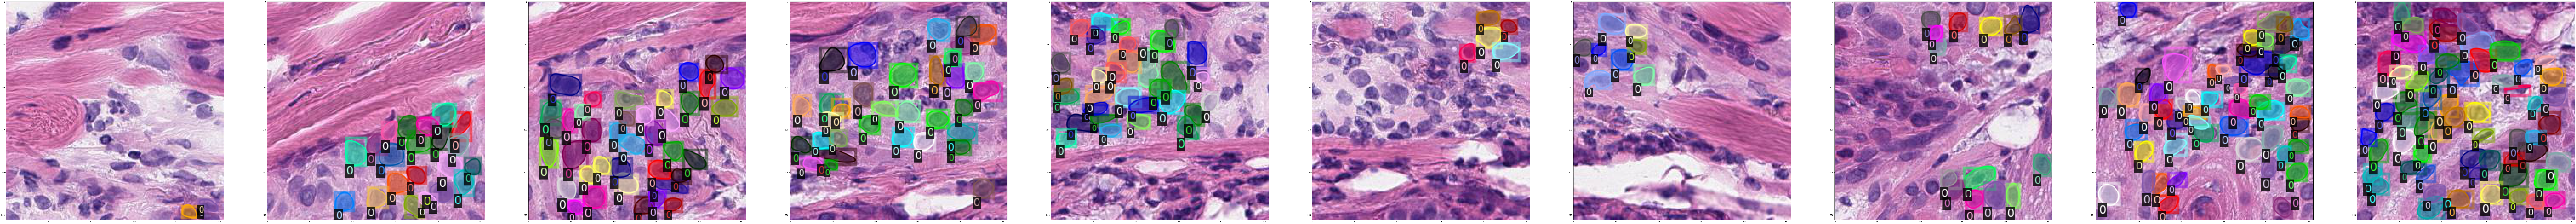

In [129]:
fig = plt.figure(figsize=(10, 10))
f, axarr = plt.subplots(1,10) 
f.set_size_inches(256, 256)
for i in range(len(data)-1):
    img = cv2.imread(data[i][0]["file_name"])
    v = Visualizer(img)
    v = v.overlay_instances(boxes=data[i][0]["instances"].gt_boxes, labels=data[i][0]["instances"].gt_classes.numpy(), masks=data[i][0]["instances"].gt_masks)
    axarr[i].imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
plt.show()

In [175]:
img = cv2.imread(data[9][0]["file_name"])
v = Visualizer(img)

In [176]:
v = v.overlay_instances(boxes=data[9][0]["instances"].gt_boxes, labels=data[9][0]["instances"].gt_classes.numpy(), masks=data[9][0]["instances"].gt_masks)


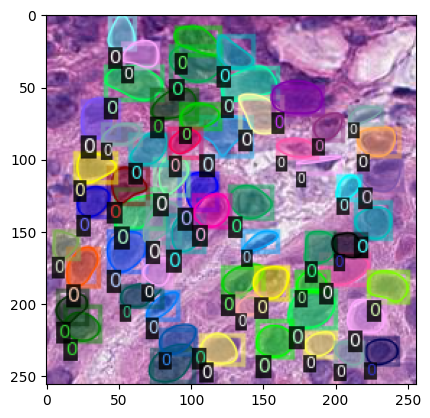

In [177]:
plt.imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
plt.show()

In [186]:
outputs = predictor(img) # now predict on this image 

In [187]:
len(outputs["instances"])

100

In [188]:
outputs["instances"]._fields

{'pred_boxes': Boxes(tensor([[223.3024, 227.2792, 237.2311, 240.7883],
         [242.7321,  31.6379, 246.9569,  36.5093],
         [238.6685,  51.7753, 251.7225,  57.3096],
         [206.6794, 113.9166, 215.5927, 124.4375],
         [218.9322, 134.4259, 236.7701, 152.4766],
         [167.1026,  44.8190, 179.3053,  49.9580],
         [  9.2611, 118.7081,  18.6224, 126.8325],
         [248.3523,  25.8321, 251.4659,  30.6681],
         [183.5836, 203.9157, 192.4190, 209.9942],
         [233.8347,  11.2594, 240.0647,  14.9934],
         [111.3151, 199.2296, 119.0125, 208.2975],
         [  6.0873,  40.8216,  14.6938,  48.9659],
         [189.9484,  56.1478, 199.6275,  63.9782],
         [ 82.0134, 239.2928,  92.2406, 244.3690],
         [ 18.1877,   7.5743,  24.9563,  11.3546],
         [ 22.5816,  15.2195,  33.5471,  20.3574],
         [147.5428, 151.5957, 159.2186, 159.5873],
         [123.1924,  65.7505, 131.5659,  70.1213],
         [175.3900, 182.5378, 182.3209, 191.2653],
         [ 

In [189]:
outputs = outputs["instances"].to("cpu")

In [190]:
# areas = outputs._fields["pred_boxes"].area()
# bool_array = []
# for i in range(len(areas)):
#     if areas[i] < 30**2 and areas[i] > 10*10: 
#         bool_array.append(True)
#     else:
#         bool_array.append(False)
# bool_array = torch.tensor(bool_array)

In [191]:
outputs._fields["pred_boxes"][bool_array]

Boxes(tensor([[183.5836, 203.9157, 192.4190, 209.9942],
        [233.8347,  11.2594, 240.0647,  14.9934],
        [189.9484,  56.1478, 199.6275,  63.9782],
        [ 82.0134, 239.2928,  92.2406, 244.3690],
        [104.4765, 118.1958, 113.0336, 128.3658],
        [241.2964,  75.6473, 248.6781,  79.9060],
        [  6.8291,  62.7421,  13.7757,  67.4638],
        [ 12.3424,  12.0058,  18.1291,  16.4513],
        [191.7831,  98.6191, 202.9067, 108.4403],
        [111.8614, 128.2544, 122.2941, 137.3848],
        [164.9362,   7.7287, 172.5604,  15.1600],
        [137.5042, 197.5084, 148.1675, 206.9074],
        [189.8284,  72.6243, 201.2476,  78.8389],
        [126.1210, 179.2949, 141.0651, 194.5651],
        [117.8038,  90.5149, 128.5595,  99.3746],
        [155.1018, 215.5216, 164.1483, 225.4641],
        [ 94.9158, 112.5972, 111.9714, 130.4948],
        [110.3498, 135.9560, 120.7706, 144.6372],
        [146.7134, 175.8726, 155.4270, 185.0667],
        [210.7296,  15.8937, 220.7370,  22.4

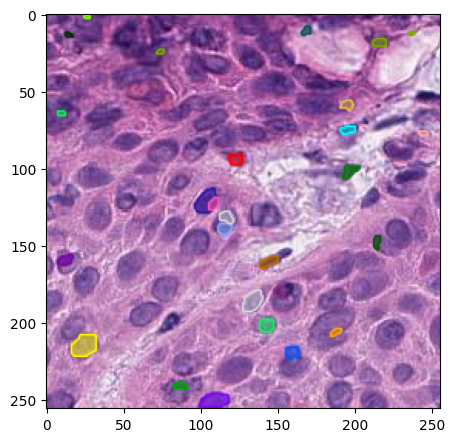

In [192]:
plt.figure(figsize=(512/100, 512/100))

v = Visualizer(img, scale=1)
v._default_font_size = 5
# v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# v = v.overlay_instances(masks = outputs["instances"]._fields["pred_masks"].to("cpu"))
v = v.overlay_instances(masks = outputs._fields["pred_masks"][bool_array])

plt.imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))

plt.show()

## Inference on test dataset

In [62]:
# from detectron2.evaluation import DatasetEvaluator
# from detectron2.evaluation import inference_on_dataset

In [165]:
 #import the COCO Evaluator to use the COCO Metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

directory = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Detectron_Detection/output/"

In [166]:
#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("nuclei_detection_test", cfg, False, output_dir="./output")
val_loader = build_detection_test_loader(cfg, "nuclei_detection_test")

WARNING [01/21 21:36:41 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/21 21:36:41 d2.evaluation.coco_evaluation]: Trying to convert 'nuclei_detection_test' to COCO format ...
WARNING [01/21 21:36:41 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/nuclei_detection_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[01/21 21:36:43 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    cell    | 1036         |
|            |              |
[01/21 21:36:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/21 21:36:43 d2.data.common]: Serializing 40 elements to byte tensors and concatenating them all ...
[01/21 21:36:46 d2

In [167]:
#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, evaluator)

[01/21 21:36:46 d2.evaluation.evaluator]: Start inference on 40 batches
[01/21 21:36:48 d2.evaluation.evaluator]: Inference done 11/40. Dataloading: 0.0008 s/iter. Inference: 0.0385 s/iter. Eval: 0.0121 s/iter. Total: 0.0514 s/iter. ETA=0:00:01
[01/21 21:36:51 d2.evaluation.evaluator]: Total inference time: 0:00:03.018546 (0.086244 s / iter per device, on 1 devices)
[01/21 21:36:51 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.041737 s / iter per device, on 1 devices)
[01/21 21:36:51 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/21 21:36:51 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[01/21 21:36:51 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[01/21 21:36:51 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[01/21 21:36:51 d2.evaluation.fast_eval_api]: COCOeval

OrderedDict([('bbox',
              {'AP': 0.0011658084406401257,
               'AP50': 0.008842636984881854,
               'AP75': 0.0,
               'APs': 0.0036149099859818755,
               'APm': 0.0,
               'APl': nan}),
             ('segm',
              {'AP': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APs': 0.0,
               'APm': 0.0,
               'APl': nan})])

In [32]:
!nvidia-smi

Tue Jan 17 23:14:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   34C    P0    51W / 300W |  11271MiB / 32768MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   